In [1]:
# Import necessary libraries
import os
from glob import glob
from pathlib import Path
import re

import numpy as np
import pandas as pd
import random
import tifffile

from skimage.measure import regionprops
from skimage.measure import regionprops_table
from skimage.measure import find_contours
from skimage.segmentation import relabel_sequential
from scipy.spatial import KDTree
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import math

In [2]:
class UnionFind:
    def __init__(self, elements):
        self.parent = {e: e for e in elements}

    def find(self, x):
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, x, y):
        self.parent[self.find(x)] = self.find(y)

    def groups(self):
        from collections import defaultdict
        result = defaultdict(list)
        for x in self.parent:
            result[self.find(x)].append(x)
        return list(result.values())

def merge_small_close_labels(label_stack, area_thresh=250, max_dist=35):
    merged_stack = []

    for i in range(label_stack.shape[0]):
        labels = label_stack[i]
        num_before = len(np.unique(labels)) - (1 if 0 in labels else 0)

        # Identify small labels
        props = regionprops(labels)
        small_props = [p for p in props if p.area < area_thresh]
        small_labels = [p.label for p in small_props]

        if not small_labels:
            merged_stack.append(labels)
            print(f"Frame {i}: Labels before = {num_before}, after = {num_before}")
            continue

        # Use centroid-based filtering with KDTree to check for proximity
        centroids = np.array([p.centroid for p in small_props])
        tree = KDTree(centroids)
        pairs = tree.query_pairs(r=max_dist)

        # Use Union-Find structure to cluster nearby small labels
        uf = UnionFind(small_labels)
        label_map = {p.label: idx for idx, p in enumerate(small_props)}
        for a, b in pairs:
            uf.union(small_props[a].label, small_props[b].label)

        clusters = [c for c in uf.groups() if len(c) > 1] # skip isolated labels
        merged = labels.copy()
        current_max = labels.max()

        for cluster in clusters:
            mask = np.isin(merged, cluster)
            current_max += 1
            merged[mask] = current_max

        # Relabel and concatenate
        merged_relabel, _, _ = relabel_sequential(merged)
        num_after = len(np.unique(merged_relabel)) - (1 if 0 in merged_relabel else 0)
        print(f"Frame {i}: Labels before = {num_before}, after = {num_after}")
        merged_stack.append(merged_relabel)

    return np.stack(merged_stack)

In [3]:
# Sample n_samples number of labels to measure for each frame
def sample_labels_and_measure(frame, frame_index, n_samples=500):
    label_ids = np.unique(frame)
    label_ids = label_ids[label_ids != 0]  # Exclude background

    if len(label_ids) > n_samples:
        random.seed(frame_index) # seed for reproducibility
        sampled_ids = random.sample(list(label_ids), n_samples)
    else:
        sampled_ids = label_ids

    # Keep only the sampled labels
    sampled_frame = np.where(np.isin(frame, sampled_ids), frame, 0)

    # Measure properties only for sampled labels
    props = regionprops_table(sampled_frame.astype(np.int32), properties=['label', 'area', 'eccentricity'])

    # Add frame number
    df = pd.DataFrame(props)
    df['frame'] = frame_index
    return df

In [4]:
# Extract region properties from labeled image
def get_properties(label_img):
    sampled_stats = []
    
    for i in range(label_img.shape[0]):
        frame = label_img[i]
        df_frame = sample_labels_and_measure(frame, frame_index=i, n_samples=500)
        sampled_stats.append(df_frame)
    
    # Combine into a single DataFrame
    sampled_stats_df = pd.concat(sampled_stats, ignore_index=True)
    return sampled_stats_df

In [5]:
# Compute KDE curve ('smoothed' historgam), KDE peak, KDE peak width for each frame
def compute_kde_per_frame(df, value_col="area", frame_col="frame", bandwidth='scott', num_points=1000):
    from scipy.stats import gaussian_kde

    frame_stats = []
    all_kde_curves = {}

    frames = sorted(df[frame_col].unique())
    x_global_min = df[value_col].min()
    x_global_max = df[value_col].max()
    x_range = np.linspace(x_global_min, x_global_max, num_points)

    for frame in frames:
        values = df[df[frame_col] == frame][value_col].dropna().values
        if len(values) < 5:
            continue  # too few data points for KDE

        kde = gaussian_kde(values, bw_method=bandwidth)
        y_kde = kde(x_range)

        # Find peak
        peak_idx = np.argmax(y_kde)
        peak_x = x_range[peak_idx]
        peak_y = y_kde[peak_idx]

        # Compute FWHM: width at half of max height
        half_max = peak_y / 2.0
        indices_above_half = np.where(y_kde >= half_max)[0]

        if len(indices_above_half) > 1:
            fwhm_x_low = x_range[indices_above_half[0]]
            fwhm_x_high = x_range[indices_above_half[-1]]
            fwhm = fwhm_x_high - fwhm_x_low
        else:
            fwhm = np.nan  # not enough points to define a width

        frame_stats.append({
            "frame": frame,
            "peak": peak_x,
            "peak_density": peak_y,
            "fwhm": fwhm
        })

        all_kde_curves[frame] = y_kde

    return pd.DataFrame(frame_stats), x_range, all_kde_curves

In [6]:
# Plot KDE curves and peaks by frame
def plot_kde_per_frame(kde_stats_df, x_range, all_kde_curves, cmap_name="plasma"):
    # Convert frame numbers to int for consistency
    kde_stats_df["frame"] = kde_stats_df["frame"].astype(int)
    all_kde_curves = {int(k): np.asarray(v) for k, v in all_kde_curves.items()}

    # Filter to frames present in both sources
    valid_frames = sorted(set(kde_stats_df["frame"]).intersection(all_kde_curves.keys()))
    kde_stats_df = kde_stats_df[kde_stats_df["frame"].isin(valid_frames)]

    # Normalize frame numbers to [0, 1] for colormap
    norm = mcolors.Normalize(vmin=min(valid_frames), vmax=max(valid_frames))
    cmap = cm.get_cmap(cmap_name)

    fig, ax = plt.subplots(figsize=(10, 6))
    for frame in valid_frames:
        y = all_kde_curves[frame]
        color = cmap(norm(frame))  # use normalized frame value to get color

        ax.plot(x_range, y, label=f"Frame {frame}", color=color)
        peak_row = kde_stats_df[kde_stats_df["frame"] == frame]
        if not peak_row.empty:
            peak = peak_row["peak"].values[0]
            peak_density = peak_row["peak_density"].values[0]
            ax.plot(peak, peak_density, 'o', color=color)

    ax.set_xscale("log")
    ax.set_xlabel("Area (log scale)")
    ax.set_ylabel("Density")
    ax.set_title("KDE of Area per Frame (Colored by Frame Number)")

    # Set Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="Frame")

    plt.tight_layout()
    plt.show()

In [7]:
# Filter labeled objects in each frame using uniform size (in pixel squared) cutoff
def filter_small_objects(label_img, min_size, max_size=None):
    filtered_label_img = np.zeros_like(label_img, dtype=np.int32)
    
    for i in range(label_img.shape[0]):
        frame = label_img[i]
        props = regionprops(frame.astype(np.int32)) 
        filtered_frame = np.zeros_like(frame, dtype=np.int32)
        
        label_id = 1
        for prop in props:
            if max_size is not None:
                if prop.area >= min_size and prop.area <= max_size:
                    filtered_frame[frame == prop.label] = label_id
                    label_id += 1
            else:
                if prop.area >= min_size:
                    filtered_frame[frame == prop.label] = label_id
                    label_id += 1

        # Relabel to ensure labels are contiguous and start at 1
        filtered_label_img[i], _, _ = relabel_sequential(filtered_frame)
                
    return filtered_label_img

In [8]:
# Filter small labeled objects in each frame using a dynamically determined threshold based on area distribution in each frame
def filter_small_objects_percentile(label_img, percentile):
    filtered_label_img = np.zeros_like(label_img, dtype=np.uint32)
    num_frames = label_img.shape[0]
    
    for i in range(num_frames):
        frame = label_img[i]
        props = regionprops(frame.astype(np.int32))
        
        if not props:
            continue

        areas = np.array([p.area for p in props])
        threshold = np.percentile(areas, percentile)

        filtered_frame = np.zeros_like(frame, dtype=np.uint32)
        label_id = 1
        
        for prop in props:
            if prop.area >= threshold:
                filtered_frame[frame == prop.label] = label_id
                label_id += 1
        
        # Optional: Relabel to ensure labels are contiguous and start at 1
        filtered_label_img[i], _, _ = relabel_sequential(filtered_frame)
    
    return filtered_label_img

In [9]:
# Visualize original labeled image and filtered labeled image side by side, for a given frame index
def show_label_comparison_with_boundaries(original_labels, filtered_labels, frame_idx):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    titles = ["Original Labels", "Filtered Labels"]
    labels = [original_labels, filtered_labels]

    for i, ax in enumerate(axes):
        frame = labels[i][frame_idx]
        ax.imshow(frame, cmap='nipy_spectral')
        ax.set_title(f"{titles[i]} (Frame {frame_idx})")
        ax.axis('off')

        # Overlay contours
        for region_id in np.unique(frame):
            if region_id == 0:
                continue  # skip background
            mask = (frame == region_id)
            contours = find_contours(mask.astype(float), level=0.5)
            for contour in contours:
                ax.plot(contour[:, 1], contour[:, 0], color='white', linewidth=0.8)

    plt.suptitle("Label Comparison with Object Boundaries", fontsize=14)
    plt.tight_layout()
    plt.show()

Frame 0: Labels before = 2691, after = 380
Frame 1: Labels before = 2906, after = 315
Frame 2: Labels before = 2870, after = 294
Frame 3: Labels before = 2899, after = 342
Frame 4: Labels before = 3805, after = 232
Frame 5: Labels before = 2853, after = 331
Frame 6: Labels before = 3107, after = 295
Frame 7: Labels before = 2954, after = 311
Frame 8: Labels before = 3246, after = 252
Frame 9: Labels before = 2844, after = 319
Frame 10: Labels before = 2934, after = 327
Frame 11: Labels before = 2748, after = 317
Frame 12: Labels before = 2453, after = 367
Frame 13: Labels before = 2618, after = 334
Frame 14: Labels before = 2348, after = 380
Frame 15: Labels before = 2371, after = 373
Frame 16: Labels before = 2245, after = 380
Frame 17: Labels before = 2361, after = 381
Frame 18: Labels before = 1934, after = 457
Frame 19: Labels before = 1876, after = 446
Frame 20: Labels before = 1845, after = 421
Frame 21: Labels before = 1430, after = 455
Frame 22: Labels before = 1144, after = 45

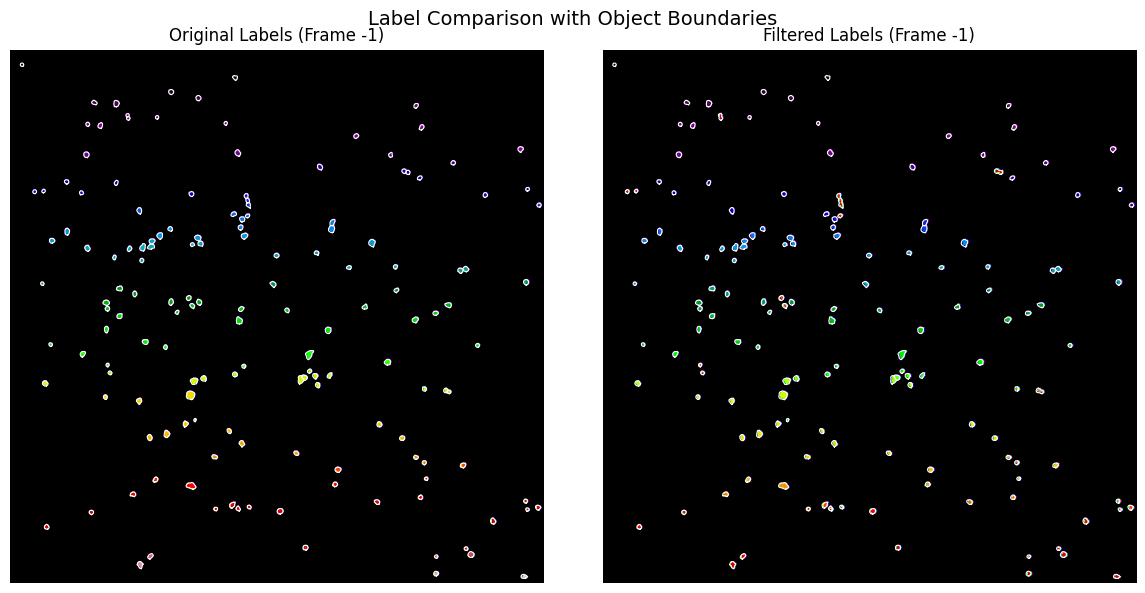

Frame 0: Labels before = 2725, after = 344
Frame 1: Labels before = 2633, after = 340
Frame 2: Labels before = 2521, after = 341
Frame 3: Labels before = 2462, after = 381
Frame 4: Labels before = 2394, after = 478
Frame 5: Labels before = 2387, after = 442
Frame 6: Labels before = 2004, after = 480
Frame 7: Labels before = 1794, after = 461
Frame 8: Labels before = 1451, after = 461
Frame 9: Labels before = 1176, after = 457
Frame 10: Labels before = 1292, after = 479
Frame 11: Labels before = 1188, after = 470
Frame 12: Labels before = 1246, after = 445
Frame 13: Labels before = 1033, after = 466
Frame 14: Labels before = 871, after = 397
Frame 15: Labels before = 898, after = 350
Frame 16: Labels before = 788, after = 359
Frame 17: Labels before = 277, after = 231
Frame 18: Labels before = 169, after = 153
Frame 19: Labels before = 149, after = 141
Frame 20: Labels before = 138, after = 131
Frame 21: Labels before = 127, after = 120
Frame 22: Labels before = 128, after = 119
Frame 2

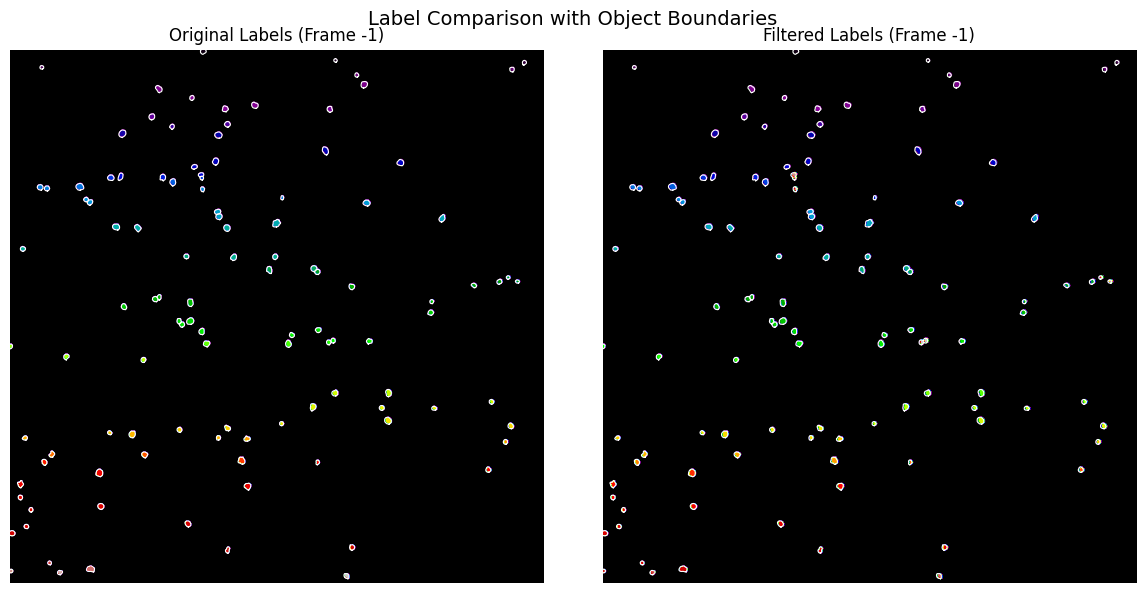

Frame 0: Labels before = 2774, after = 364
Frame 1: Labels before = 2428, after = 409
Frame 2: Labels before = 2613, after = 380
Frame 3: Labels before = 2765, after = 475
Frame 4: Labels before = 2559, after = 595
Frame 5: Labels before = 2104, after = 614
Frame 6: Labels before = 1992, after = 700
Frame 7: Labels before = 2424, after = 604
Frame 8: Labels before = 2142, after = 628
Frame 9: Labels before = 1827, after = 628
Frame 10: Labels before = 2077, after = 628
Frame 11: Labels before = 1608, after = 655
Frame 12: Labels before = 1638, after = 589
Frame 13: Labels before = 1582, after = 604
Frame 14: Labels before = 725, after = 481
Frame 15: Labels before = 605, after = 379
Frame 16: Labels before = 782, after = 452
Frame 17: Labels before = 360, after = 274
Frame 18: Labels before = 353, after = 272
Frame 19: Labels before = 284, after = 225
Frame 20: Labels before = 256, after = 214
Frame 21: Labels before = 149, after = 148
Frame 22: Labels before = 156, after = 152
Frame 2

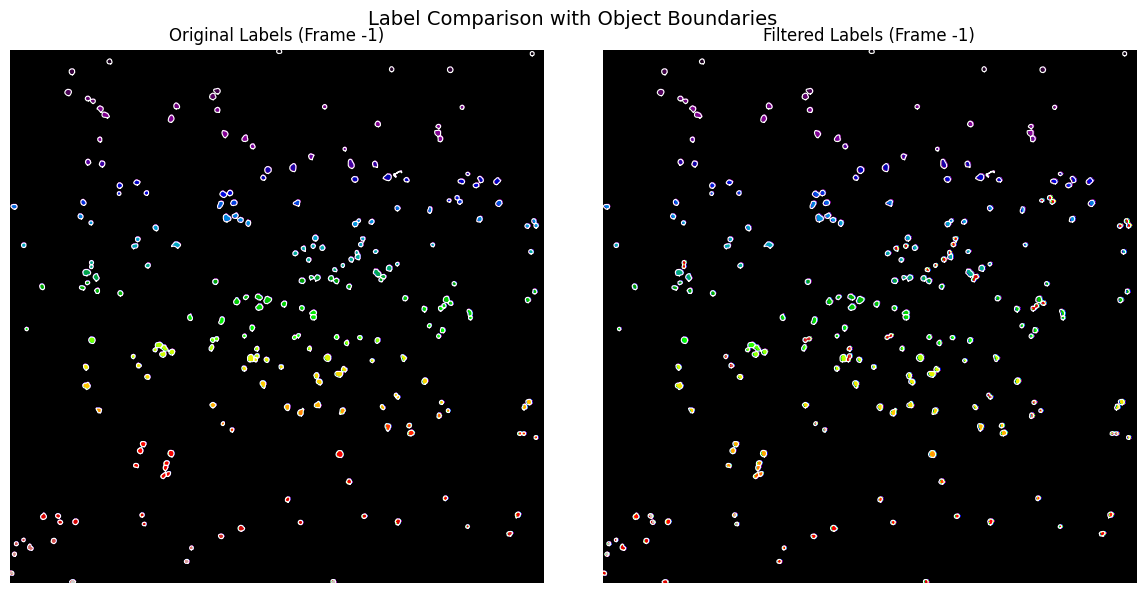

Frame 0: Labels before = 2367, after = 523
Frame 1: Labels before = 1694, after = 537
Frame 2: Labels before = 1974, after = 520
Frame 3: Labels before = 1688, after = 573
Frame 4: Labels before = 1601, after = 613
Frame 5: Labels before = 1280, after = 606
Frame 6: Labels before = 1380, after = 564
Frame 7: Labels before = 1334, after = 606
Frame 8: Labels before = 964, after = 506
Frame 9: Labels before = 837, after = 518
Frame 10: Labels before = 391, after = 314
Frame 11: Labels before = 781, after = 485
Frame 12: Labels before = 785, after = 475
Frame 13: Labels before = 510, after = 360
Frame 14: Labels before = 348, after = 269
Frame 15: Labels before = 285, after = 238
Frame 16: Labels before = 185, after = 170
Frame 17: Labels before = 112, after = 103
Frame 18: Labels before = 130, after = 127
Frame 19: Labels before = 120, after = 113
Frame 20: Labels before = 117, after = 115
Frame 21: Labels before = 115, after = 109
Frame 22: Labels before = 131, after = 126
Frame 23: Lab

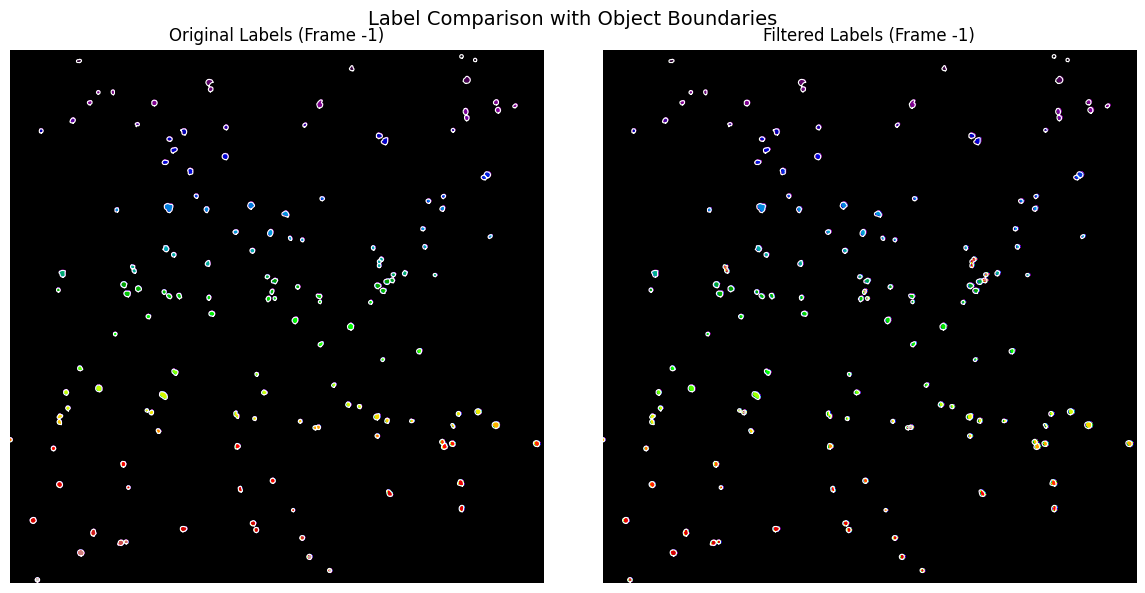

In [11]:
# Batch merge fragmented nuclei in PI channel labeled images
master_folder = '/home/vil945/live_cell_imaging/2025-06-18_live_cell_imaging'

# Recursively find folders with '_PI_segmented' in their names
target_folders = []
for root, dirs, files in os.walk(master_folder):    
    for dir_name in dirs:
        if '_join_fragments' in dir_name:
            continue  # Skip processed folders themselves
        if '_PI_segmented' in dir_name:
            target_folders.append(os.path.join(root, dir_name))

# Process each matching folder
for folder in target_folders:
    input_files = glob(os.path.join(folder, '*.tif'))
    if not input_files:
        continue  # Skip empty folders

    # Create output folder inside the current one
    folder_name = os.path.basename(folder)
    output_folder = os.path.join(folder, f'{folder_name}_join_fragments')
    os.makedirs(output_folder, exist_ok=True)

    for filepath in input_files:
        sample_idx = re.findall(r'xy(\d+)', filepath) # for naming output files        
        label_stack = tifffile.imread(filepath) # read multi-frame labeled image
        
        PI_merged_stack = merge_small_close_labels(label_stack, area_thresh=500, max_dist=60) # call merge fragmented nuclei function
        show_label_comparison_with_boundaries(label_stack, PI_merged_stack, -1) # show original label and merged label side-by-side

        tifffile.imwrite(f'{output_folder}/xy{sample_idx[-1]}_PI_merged_labels.tif', PI_merged_stack.astype(np.uint16))


/tmp/ipykernel_2735917/5581514.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


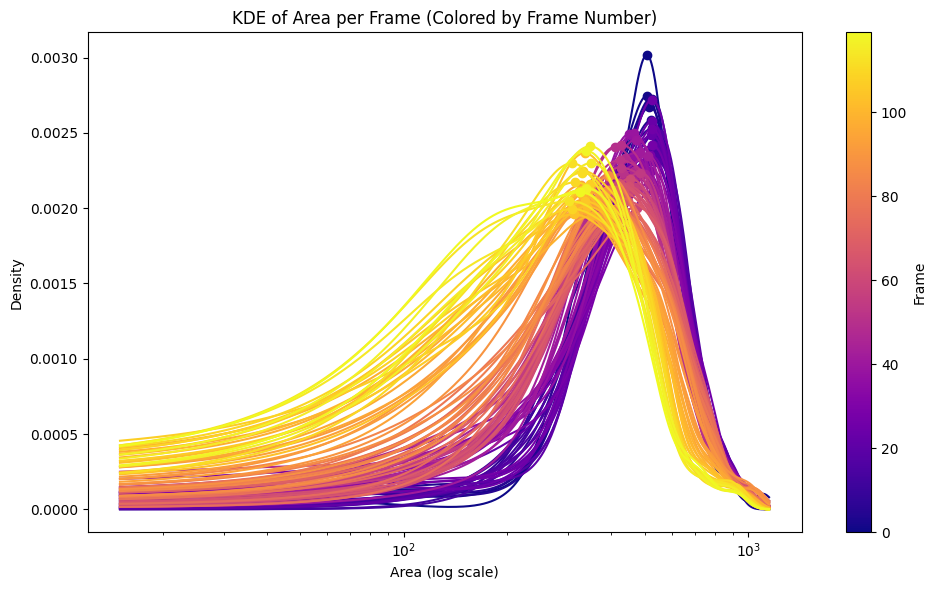

/tmp/ipykernel_2735917/5581514.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


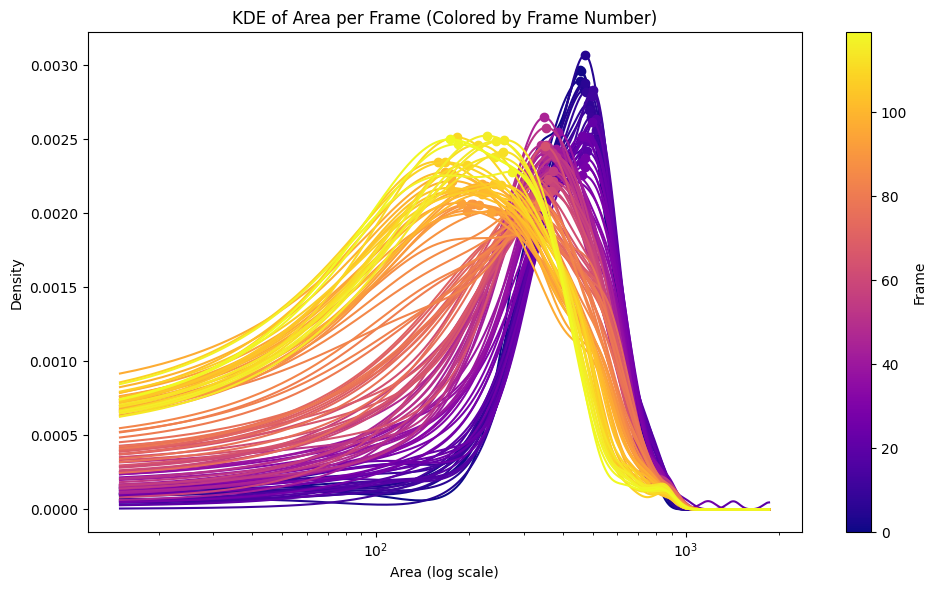

/tmp/ipykernel_2735917/5581514.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


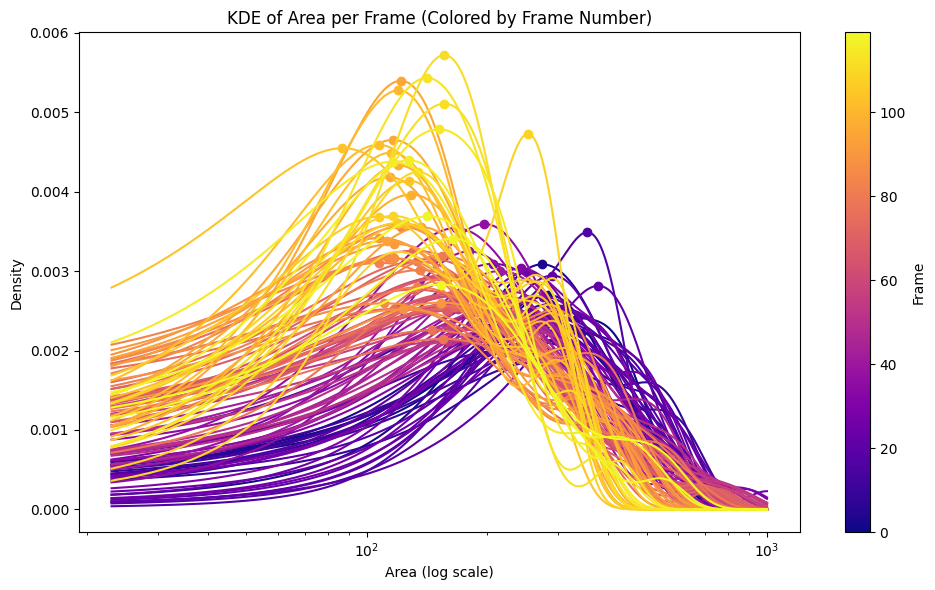

Sample1 mCherry channel KDE curve mean peak across all frames: 434.99 pixels squared
Sample1 GFP channel KDE curve mean peak across all frames: 344.92 pixels squared
Sample1 CTV channel KDE curve mean peak across all frames: 189.57 pixels squared


/tmp/ipykernel_2735917/5581514.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


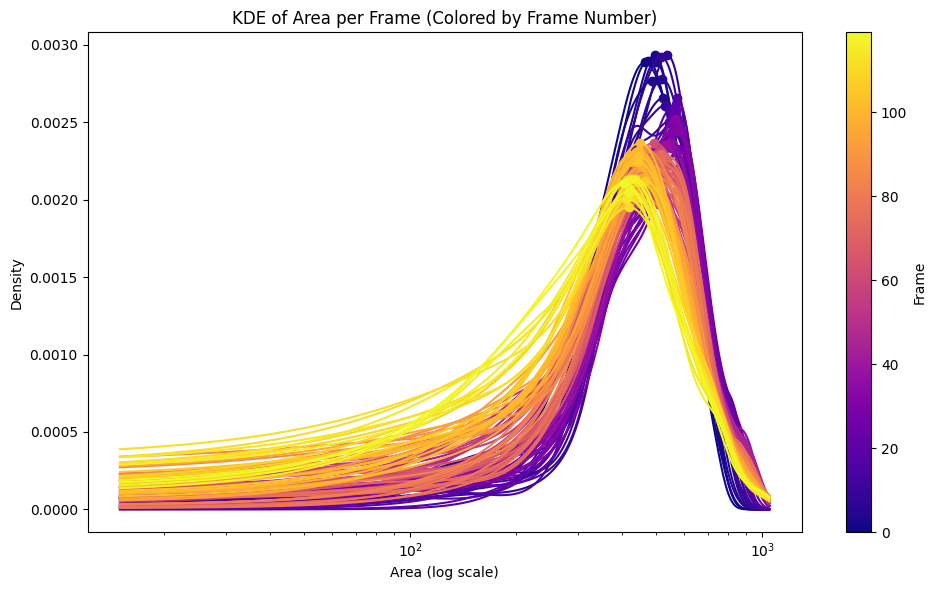

/tmp/ipykernel_2735917/5581514.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


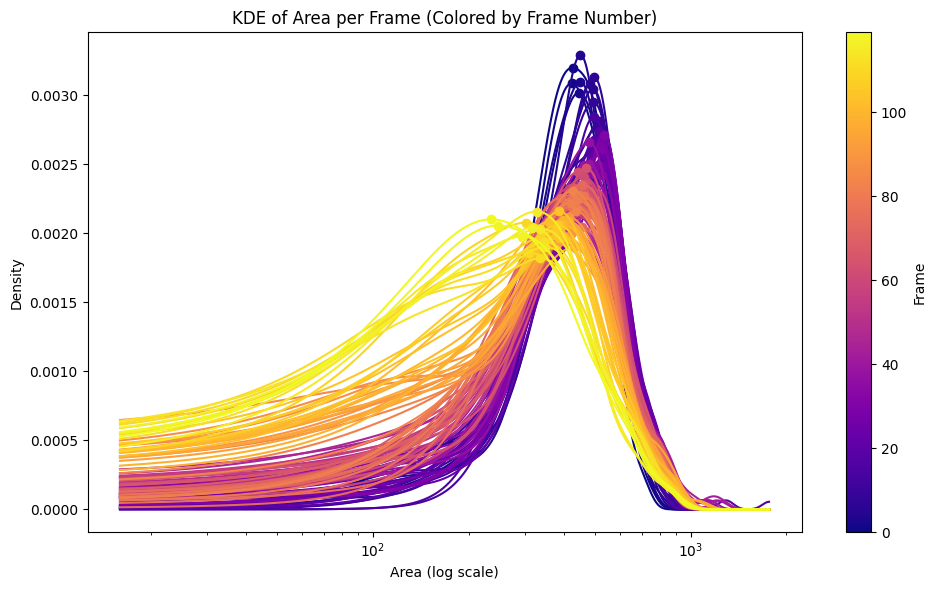

/tmp/ipykernel_2735917/5581514.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


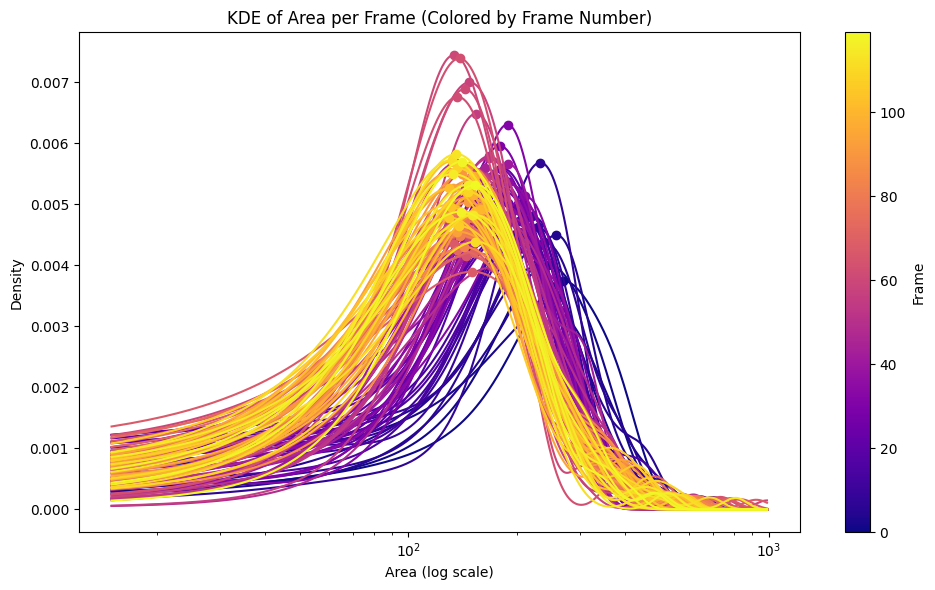

Sample2 mCherry channel KDE curve mean peak across all frames: 489.98 pixels squared
Sample2 GFP channel KDE curve mean peak across all frames: 438.44 pixels squared
Sample2 CTV channel KDE curve mean peak across all frames: 164.96 pixels squared


In [10]:
# Batch load image stack properties and visualize
master_folder = '/home/vil945/live_cell_imaging/2025-09-30_live_cell_imaging'

# Recursively find folders with "PI_segmented_join_fragments", "YFP_segmented", "CTV_segmented"
mCherry_files = []
GFP_files = []
CTV_files = []
for root, dirs, files in os.walk(master_folder):
    path = Path(root)
    if "mCherry_segmented" in path.name:
        mCherry_files = list(path.glob("*.tif"))
    if "GFP_segmented" in path.name:
        GFP_files = list(path.glob("*.tif"))
    if "CTV_segmented" in path.name:
        CTV_files = list(path.glob("*.tif"))

# Match groups of fours of iRFP670, PI, YFP, CTV channels segmentation results by matching index i within their file names containing "xy[i]"

# Dictionaries: key = index i, value = file path
mCherry_imgs = {}
GFP_imgs = {}
CTV_imgs = {}

for f in mCherry_files:
    mCherry_match = re.search(r'sample(\d+)_mCherry', f.name)
    if mCherry_match:
        idx = mCherry_match.group(1)
        mCherry_imgs[idx] = f
for f in GFP_files:
    GFP_match = re.search(r'sample(\d+)_GFP', f.name)
    if GFP_match:
        idx = GFP_match.group(1)
        GFP_imgs[idx] = f
for f in CTV_files:
    CTV_match = re.search(r'sample(\d+)_CTV', f.name)
    if CTV_match:
        idx = CTV_match.group(1)
        CTV_imgs[idx] = f


matched_indices = sorted(set(mCherry_imgs.keys()) & set(GFP_imgs.keys()) & set(CTV_imgs.keys()))
mCherry_lbls = []
GFP_lbls = []
CTV_lbls = []

for i in matched_indices:
    mCherry_img = mCherry_imgs[i]
    GFP_img = GFP_imgs[i]
    CTV_img = CTV_imgs[i]

    # Load labeled images
    mCherry_labels = tifffile.imread(mCherry_img)
    GFP_labels = tifffile.imread(GFP_img)
    CTV_labels = tifffile.imread(CTV_img)

    mCherry_lbls.append(mCherry_labels)
    GFP_lbls.append(GFP_labels)
    CTV_lbls.append(CTV_labels)

    # Get properties
    mCherry_props = get_properties(mCherry_labels)
    GFP_props = get_properties(GFP_labels)
    CTV_props = get_properties(CTV_labels)

    # Visualize area distribution of each channel (order: iRFP, PI, CTV, YFP)
    mCherry_kde_stats_df, mCherry_x_range, mCherry_all_kde_curves = compute_kde_per_frame(mCherry_props, value_col="area")
    plot_kde_per_frame(mCherry_kde_stats_df, mCherry_x_range, mCherry_all_kde_curves)

    GFP_kde_stats_df, GFP_x_range, GFP_all_kde_curves = compute_kde_per_frame(GFP_props, value_col="area")
    plot_kde_per_frame(GFP_kde_stats_df, GFP_x_range, GFP_all_kde_curves)

    CTV_kde_stats_df, CTV_x_range, CTV_all_kde_curves = compute_kde_per_frame(CTV_props, value_col="area")
    plot_kde_per_frame(CTV_kde_stats_df, CTV_x_range, CTV_all_kde_curves)

    mCherry_peak_mean = mCherry_kde_stats_df['peak'].mean()
    GFP_peak_mean = GFP_kde_stats_df['peak'].mean()
    CTV_peak_mean = CTV_kde_stats_df['peak'].mean()
    print(f"Sample{i} mCherry channel KDE curve mean peak across all frames: {mCherry_peak_mean:.2f} pixels squared")
    print(f"Sample{i} GFP channel KDE curve mean peak across all frames: {GFP_peak_mean:.2f} pixels squared")
    print(f"Sample{i} CTV channel KDE curve mean peak across all frames: {CTV_peak_mean:.2f} pixels squared")

mCherry_lbls_stack = np.stack(mCherry_lbls)
GFP_lbls_stack = np.stack(GFP_lbls)
CTV_lbls_stack = np.stack(CTV_lbls)

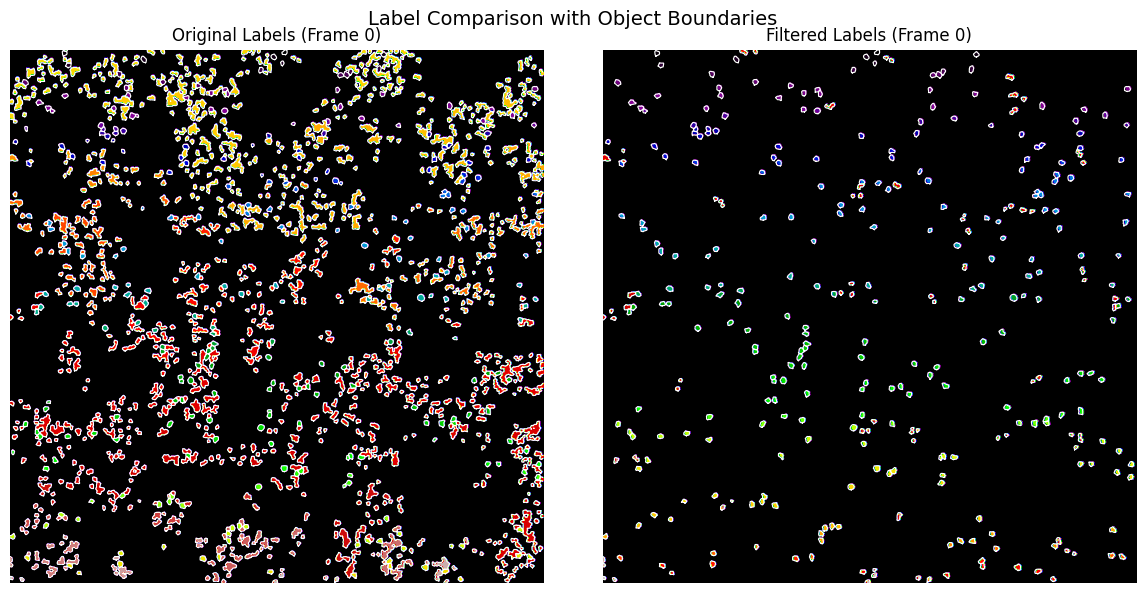

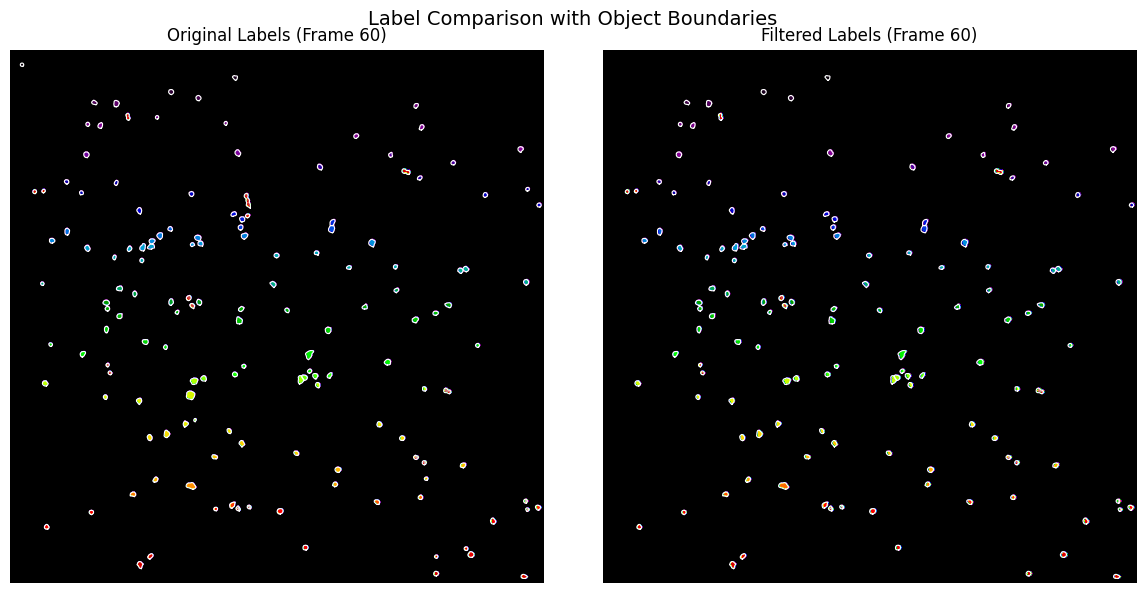

Sample xy1 PI channel filtering complete


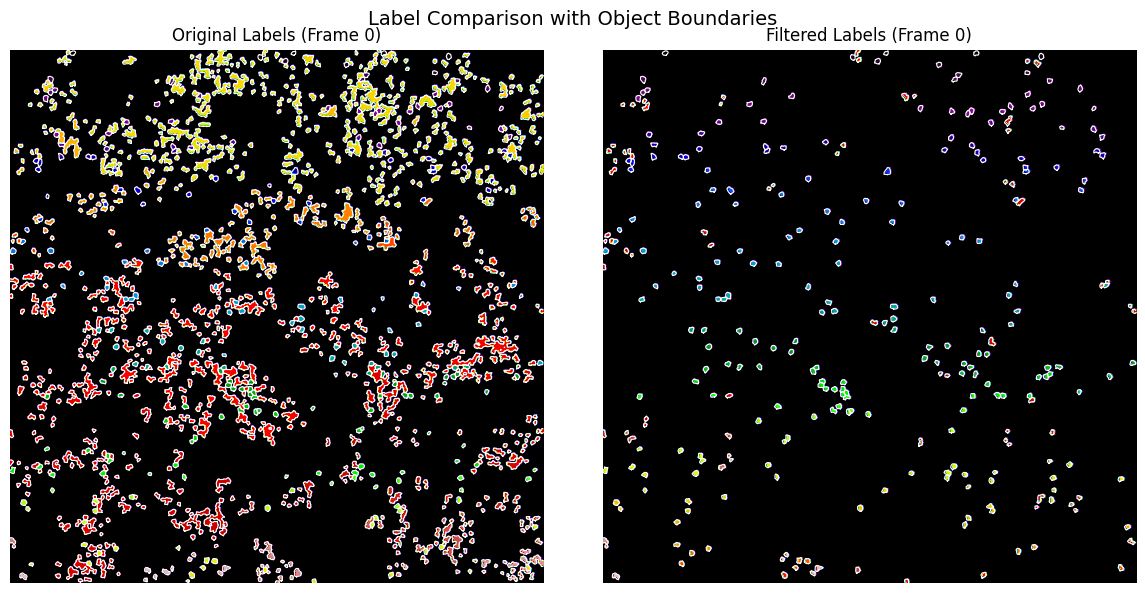

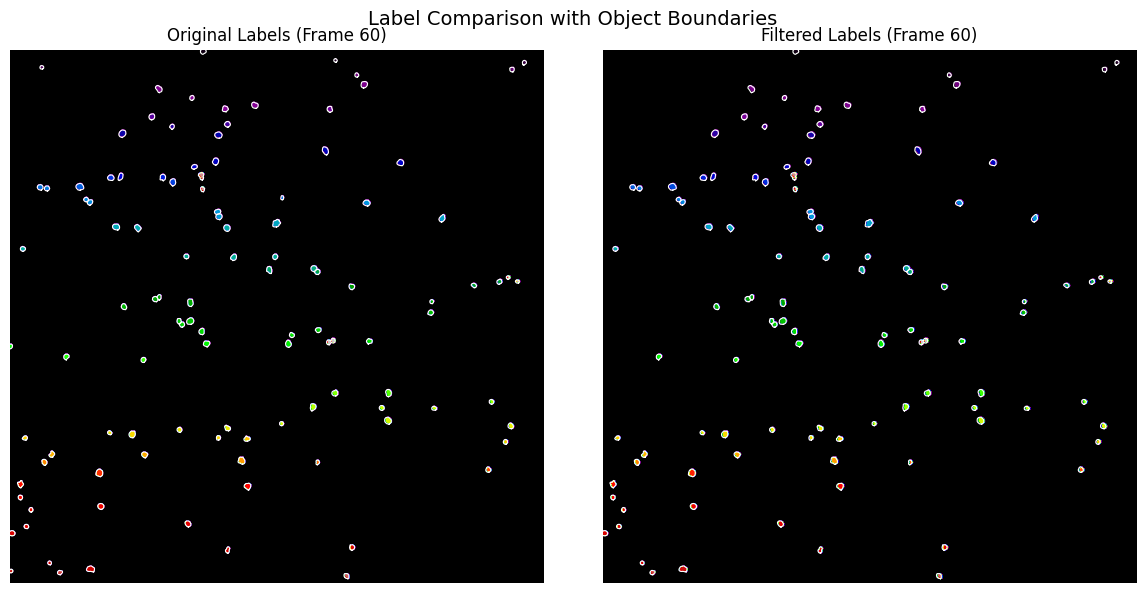

Sample xy2 PI channel filtering complete


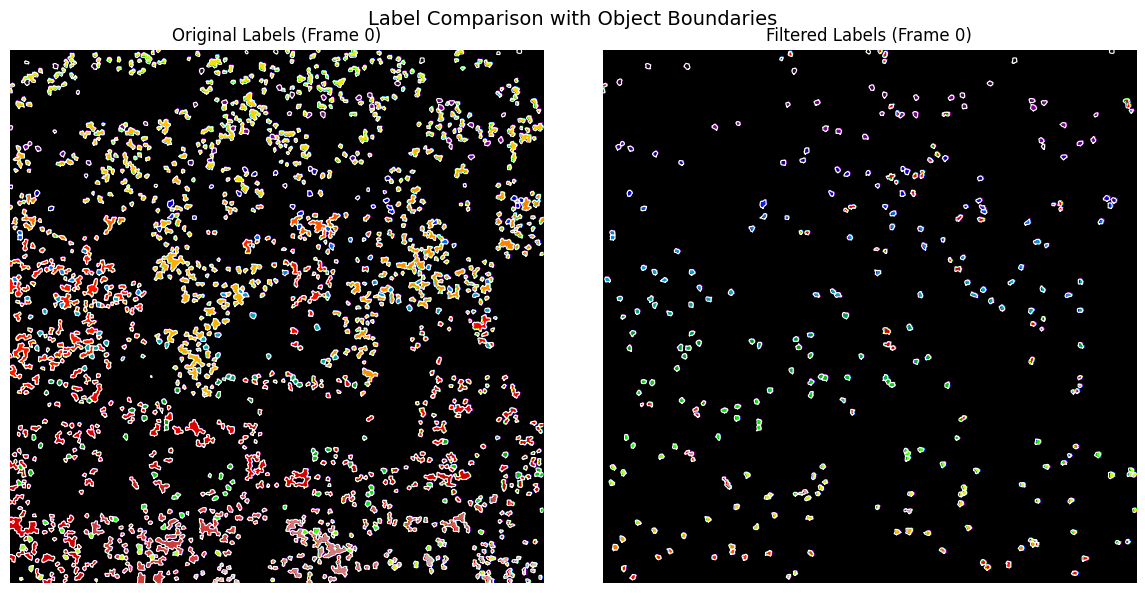

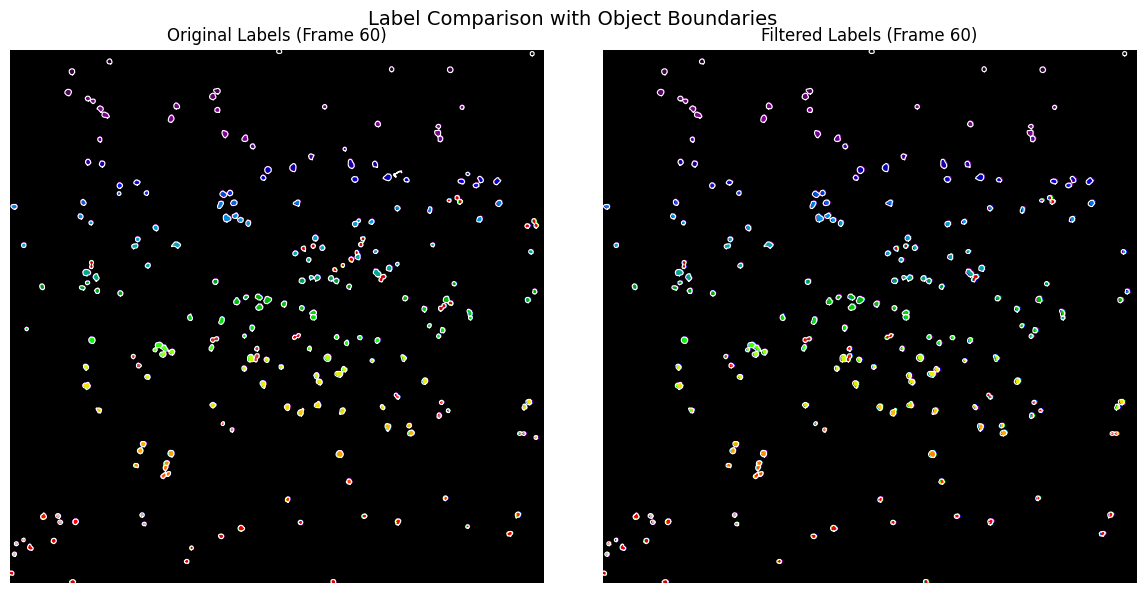

Sample xy3 PI channel filtering complete


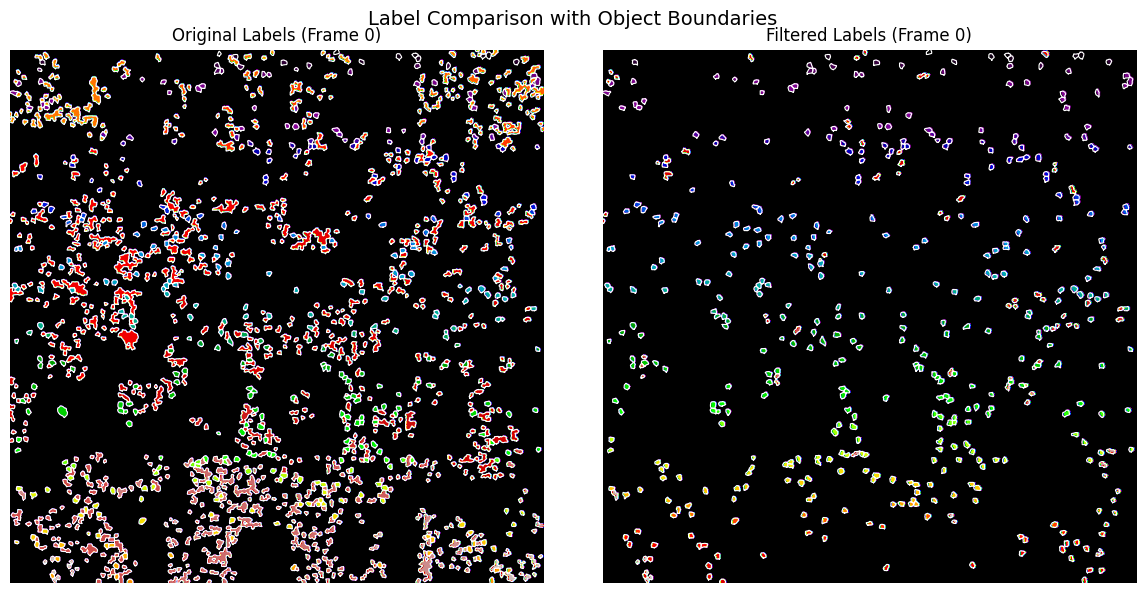

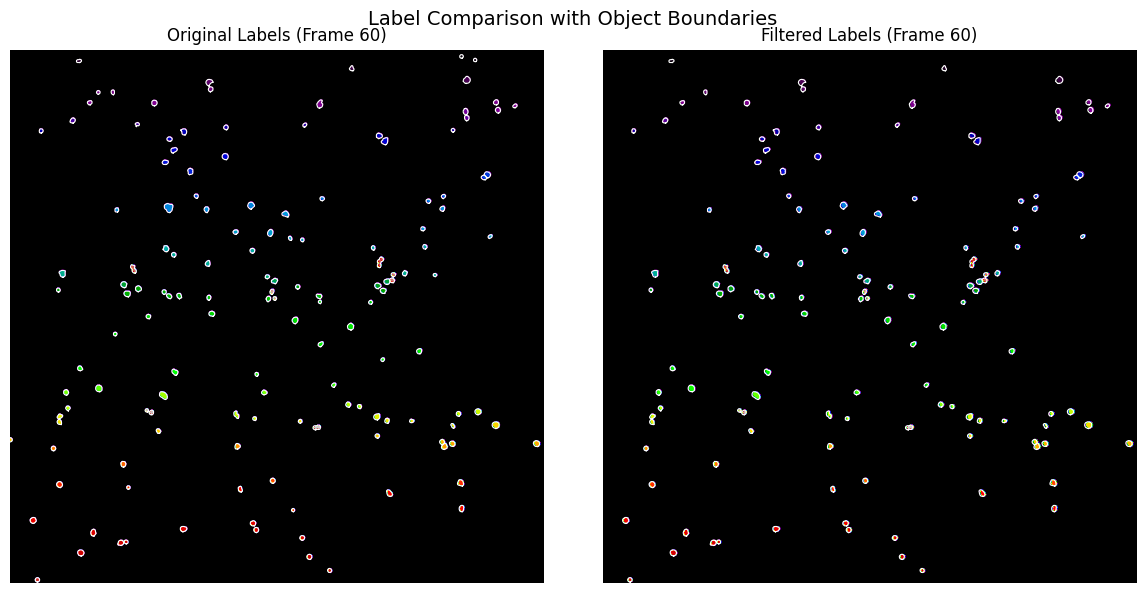

Sample xy4 PI channel filtering complete


'\n# YFP channel\nfor lbl, sample_idx in zip(YFP_lbls_stack, YFP_imgs.keys()):\n    YFP_filtered = filter_small_objects_percentile(lbl, 15)\n\n    # Visualize pre- and post- filter of first and last frame\n    show_label_comparison_with_boundaries(lbl, YFP_filtered, 0)\n    show_label_comparison_with_boundaries(lbl, YFP_filtered, lbl.shape[0] - 1)\n\n    # Save filtered result\n    tifffile.imwrite(f\'{filter_folder}/xy{sample_idx}_YFP_filtered_labels.tif\', YFP_filtered.astype(np.uint16))\n    print(f"Sample xy{sample_idx} YFP channel filtering complete")\n'

In [14]:
# Batch filter labeled images and save filtered result

filter_folder = os.path.join(master_folder, 'filtered_segmentation')
os.makedirs(filter_folder, exist_ok=True)

'''
Recommended filter parameters:
PI channel: set the lower limit slightly above the mean peak of the CTV channel KDE curves (usually ~300) and the upper limit ~1300
iRFP670 and YFP channels: set between 7th-16th percentile (equivalent to peak - 1.5*width, peak - width)
'''

# iRFP670 channel
for lbl, sample_idx in zip(iRFP_lbls_stack, iRFP_imgs.keys()):
    iRFP_filtered = filter_small_objects_percentile(lbl, 15)

    # Visualize pre- and post- filter of first and last frame
    show_label_comparison_with_boundaries(lbl, iRFP_filtered, 0)
    show_label_comparison_with_boundaries(lbl, iRFP_filtered, lbl.shape[0] - 1)

    # Save filtered result
    tifffile.imwrite(f'{filter_folder}/xy{sample_idx}_iRFP670_filtered_labels.tif', iRFP_filtered.astype(np.uint16))
    print(f"Sample xy{sample_idx} iRFP670 channel filtering complete")


# PI channel
for lbl, sample_idx in zip(PI_lbls_stack, PI_imgs.keys()):
    PI_filtered = filter_small_objects(lbl, 300, 1300)

    # Visualize pre- and post- filter of first and last frame
    show_label_comparison_with_boundaries(lbl, PI_filtered, 0)
    show_label_comparison_with_boundaries(lbl, PI_filtered, lbl.shape[0] - 1)

    # Save filtered result
    tifffile.imwrite(f'{filter_folder}/xy{sample_idx}_PI_filtered_labels.tif', PI_filtered.astype(np.uint16))
    print(f"Sample xy{sample_idx} PI channel filtering complete")


# YFP channel
for lbl, sample_idx in zip(YFP_lbls_stack, YFP_imgs.keys()):
    YFP_filtered = filter_small_objects_percentile(lbl, 15)

    # Visualize pre- and post- filter of first and last frame
    show_label_comparison_with_boundaries(lbl, YFP_filtered, 0)
    show_label_comparison_with_boundaries(lbl, YFP_filtered, lbl.shape[0] - 1)

    # Save filtered result
    tifffile.imwrite(f'{filter_folder}/xy{sample_idx}_YFP_filtered_labels.tif', YFP_filtered.astype(np.uint16))
    print(f"Sample xy{sample_idx} YFP channel filtering complete")
